In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import soundfile as sf

import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), "../"))
if project_root not in sys.path:
    sys.path.append(project_root)

# CWD is assumed to be notebooks/icbhi
CWD = Path().resolve()

# heart_and_lungsounds/
PROJECT_ROOT = CWD.parents[1]

RAW_ROOT = PROJECT_ROOT / "data" / "raw" / "icbhi"
AUDIO_DIR = RAW_ROOT / "audio_and_txt_files"
PATIENT_CSV = RAW_ROOT / "patient_diagnosis.csv"

print("CWD         :", CWD)
print("PROJECT_ROOT:", PROJECT_ROOT)
print("RAW_ROOT    :", RAW_ROOT)
print("AUDIO_DIR   :", AUDIO_DIR)
print("PATIENT_CSV :", PATIENT_CSV)

from src.plot_style import set_default_style
from src.plots import histplot, countplot

set_default_style()

CWD         : C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\notebooks\icbhi
PROJECT_ROOT: C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds
RAW_ROOT    : C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\raw\icbhi
AUDIO_DIR   : C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\raw\icbhi\audio_and_txt_files
PATIENT_CSV : C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\raw\icbhi\patient_diagnosis.csv


In [2]:
def audio_file_metadata(path: Path) -> dict:
    info = sf.info(str(path))
    duration_sec = info.frames / info.samplerate
    patient_id = int(path.stem.split("_")[0])  # first part before underscore

    return {
        "path": str(path),
        "file_name": path.name,
        "samplerate": info.samplerate,
        "frames": info.frames,
        "duration_sec": duration_sec,
        "channels": info.channels,
        "patient_id": patient_id,
    }

In [3]:
wav_paths = sorted(AUDIO_DIR.glob("*.wav"))
records = [audio_file_metadata(p) for p in wav_paths]
audio_df = pd.DataFrame(records)

In [4]:
patients_df = pd.read_csv(PATIENT_CSV, header=None)
patients_df.columns = ["patient_id", "diagnosis"]

print("Audio files:", len(audio_df))
print("Unique patients (audio):", audio_df["patient_id"].nunique())
print("Patients (diagnosis CSV):", len(patients_df))

Audio files: 920
Unique patients (audio): 126
Patients (diagnosis CSV): 126


In [5]:
audio_df.head()

,path,file_name,samplerate,frames,duration_sec,channels,patient_id
0,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,101_1b1_Al_sc_Meditron.wav,44100,882000,20.000,1,101
1,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,101_1b1_Pr_sc_Meditron.wav,44100,882000,20.000,1,101
2,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,102_1b1_Ar_sc_Meditron.wav,44100,882000,20.000,1,102
3,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,103_2b2_Ar_mc_LittC2SE.wav,44100,882000,20.000,1,103
4,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,104_1b1_Al_sc_Litt3200.wav,4000,63424,15.856,1,104


In [6]:
patients_df.head()

,patient_id,diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [7]:
# Check expected number of recordings (from dataset description)
EXPECTED_N_WAV = 920  # ICBHI description
if len(audio_df) != EXPECTED_N_WAV:
    print(f"WARNING: expected {EXPECTED_N_WAV} wav files, found {len(audio_df)}")
else:
    print("OK: number of wav files matches expectation.")

OK: number of wav files matches expectation.


In [8]:
# Check samplerates and channels
print("Samplerates:", audio_df["samplerate"].value_counts())
print("\nChannels:", audio_df["channels"].value_counts())

Samplerates: samplerate
44100    824
4000      90
10000      6
Name: count, dtype: int64

Channels: channels
1    920
Name: count, dtype: int64


In [9]:
# Quick distribution of durations
audio_df["duration_sec"].describe()

count    920.000000
mean      21.492424
std        8.307421
min        7.856000
25%       20.000000
50%       20.000000
75%       20.000000
max       86.200000
Name: duration_sec, dtype: float64

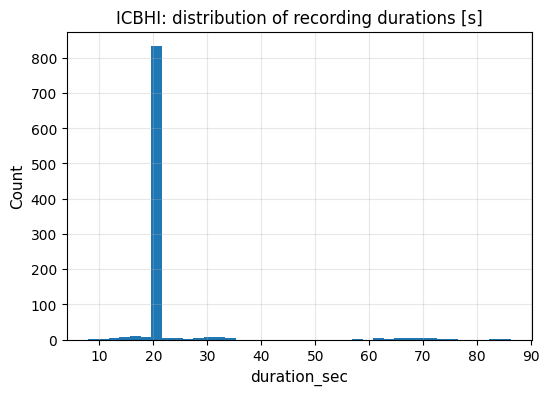

In [10]:
fig, ax = plt.subplots()
histplot(audio_df, "duration_sec", bins=40, ax=ax, title="ICBHI: distribution of recording durations [s]")
plt.show()

In [11]:
def parse_icbhi_filename(file_name: str) -> dict:
    """
    Parse an ICBHI wav file name into components.
    <patient>_<recindex>_<chestlocation>_<mode>_<equipment>.wav
    """
    stem = file_name
    if stem.lower().endswith(".wav"):
        stem = stem[:-4]

    parts = stem.split("_")
    chest_location = parts[2] if len(parts) > 2 else None
    mode = parts[3] if len(parts) > 3 else None
    equipment = parts[4] if len(parts) > 4 else None

    return {
        "chest_location": chest_location,
        "mode": mode,
        "equipment": equipment,
    }


parsed = audio_df["file_name"].apply(parse_icbhi_filename).apply(pd.Series)
audio_df = audio_df.drop(
    columns=[c for c in ["chest_location", "mode", "equipment"] if c in audio_df.columns], # type: ignore
    errors="ignore",
)
audio_df = audio_df.join(parsed)
audio_df.head()

,path,file_name,samplerate,frames,duration_sec,channels,patient_id,chest_location,mode,equipment
0,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,101_1b1_Al_sc_Meditron.wav,44100,882000,20.000,1,101,Al,sc,Meditron
1,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,101_1b1_Pr_sc_Meditron.wav,44100,882000,20.000,1,101,Pr,sc,Meditron
2,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,102_1b1_Ar_sc_Meditron.wav,44100,882000,20.000,1,102,Ar,sc,Meditron
3,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,103_2b2_Ar_mc_LittC2SE.wav,44100,882000,20.000,1,103,Ar,mc,LittC2SE
4,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,104_1b1_Al_sc_Litt3200.wav,4000,63424,15.856,1,104,Al,sc,Litt3200


In [12]:
print("Chest locations:", sorted(audio_df["chest_location"].dropna().unique()))
print("Modes:", sorted(audio_df["mode"].dropna().unique()))
print("Equipment:", sorted(audio_df["equipment"].dropna().unique()))

Chest locations: ['Al', 'Ar', 'Ll', 'Lr', 'Pl', 'Pr', 'Tc']
Modes: ['mc', 'sc']
Equipment: ['AKGC417L', 'Litt3200', 'LittC2SE', 'Meditron']


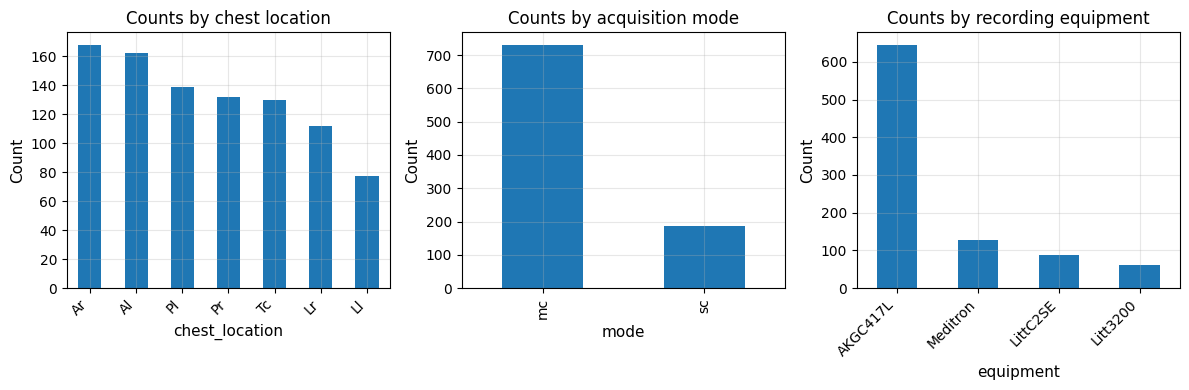

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

countplot(audio_df, "chest_location", ax=axes[0], title="Counts by chest location")
countplot(audio_df, "mode", ax=axes[1], title="Counts by acquisition mode", rotate_xticks=False)
countplot(audio_df, "equipment", ax=axes[2], title="Counts by recording equipment", rotate_xticks=True)

fig.tight_layout()
plt.show()

In [14]:
df = audio_df.merge(patients_df, on="patient_id", how="left")

print("Rows after merge:", len(df))
print("Missing diagnosis:", df["diagnosis"].isna().sum())

df.head()

Rows after merge: 920
Missing diagnosis: 0


,path,file_name,samplerate,frames,duration_sec,channels,patient_id,chest_location,mode,equipment,diagnosis
0,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,101_1b1_Al_sc_Meditron.wav,44100,882000,20.000,1,101,Al,sc,Meditron,URTI
1,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,101_1b1_Pr_sc_Meditron.wav,44100,882000,20.000,1,101,Pr,sc,Meditron,URTI
2,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,102_1b1_Ar_sc_Meditron.wav,44100,882000,20.000,1,102,Ar,sc,Meditron,Healthy
3,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,103_2b2_Ar_mc_LittC2SE.wav,44100,882000,20.000,1,103,Ar,mc,LittC2SE,Asthma
4,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,104_1b1_Al_sc_Litt3200.wav,4000,63424,15.856,1,104,Al,sc,Litt3200,COPD


In [15]:
# Possible Missing Diagnoses
missing_patients = (
    df.loc[df["diagnosis"].isna(), "patient_id"]
    .drop_duplicates()
    .sort_values()
    .tolist()
)
missing_patients[:20], len(missing_patients)

([], 0)

In [16]:
# Basic stats by diagnosis
diag_counts = df["diagnosis"].value_counts(dropna=False)
diag_counts

diagnosis
COPD              793
Pneumonia          37
Healthy            35
URTI               23
Bronchiectasis     16
Bronchiolitis      13
LRTI                2
Asthma              1
Name: count, dtype: int64

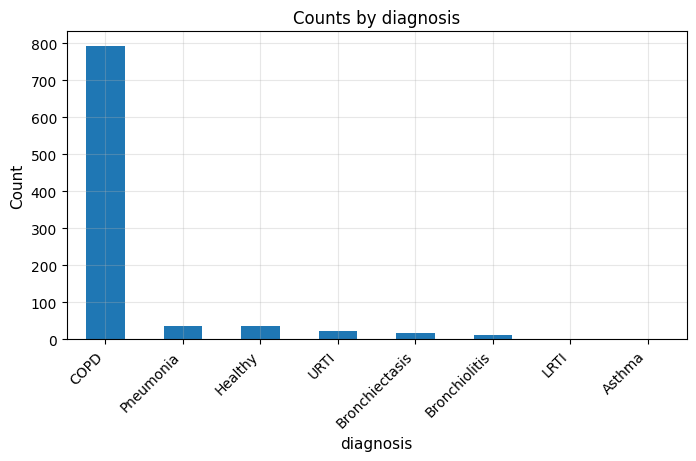

In [17]:
fig, ax = plt.subplots(figsize=(8, 4))
countplot(df, "diagnosis", ax=ax, title="Counts by diagnosis")
plt.show()

C:\Users\Esmee Werk\AppData\Local\Temp\ipykernel_11556\3974967099.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


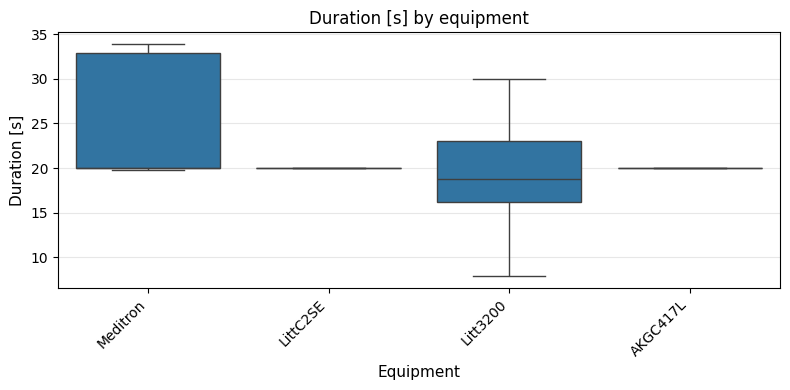

In [18]:
# Duration by equipment
fig, ax = plt.subplots(figsize=(8, 4))
if "seaborn" in sys.modules:
    sns.boxplot(
        data=df,
        x="equipment",
        y="duration_sec",
        ax=ax,
        showfliers=False,
    )
    ax.set_title("Duration [s] by equipment")
    ax.set_xlabel("Equipment")
    ax.set_ylabel("Duration [s]")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [19]:
per_patient = df.groupby("patient_id").size().rename("n_recordings")
per_patient.describe()

count    126.000000
mean       7.301587
std        9.519050
min        1.000000
25%        1.000000
50%        3.000000
75%        8.000000
max       66.000000
Name: n_recordings, dtype: float64

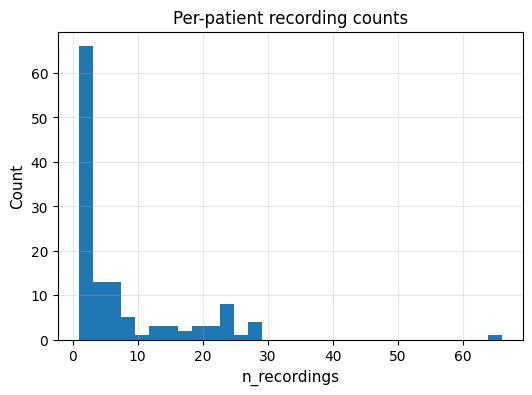

In [20]:
fig, ax = plt.subplots()
histplot(per_patient.to_frame(), "n_recordings", bins=30, ax=ax, title="Per-patient recording counts")
plt.show()

C:\Users\Esmee Werk\AppData\Local\Temp\ipykernel_11556\854733444.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


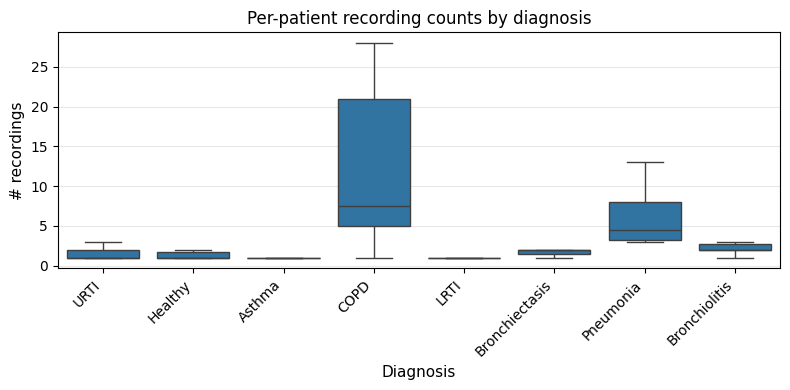

In [21]:
# Attach diagnosis at patient level (one diagnosis per patient)
patient_diag = patients_df.set_index("patient_id")["diagnosis"]
per_patient_diag = per_patient.to_frame().join(patient_diag)

fig, ax = plt.subplots(figsize=(8, 4))
if "seaborn" in sys.modules:
    sns.boxplot(
        data=per_patient_diag.reset_index(),
        x="diagnosis",
        y="n_recordings",
        ax=ax,
        showfliers=False,
    )
    ax.set_title("Per-patient recording counts by diagnosis")
    ax.set_xlabel("Diagnosis")
    ax.set_ylabel("# recordings")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [22]:
def run_sanity_asserts(df_audio: pd.DataFrame, df_patients: pd.DataFrame):
    # At least one recording per patient in diagnosis table? (not strictly required)
    n_with_audio = df_patients["patient_id"].isin(df_audio["patient_id"]).sum()
    print(f"Patients with at least one recording: {n_with_audio}/{len(df_patients)}")

    # No zero-duration files
    n_zero = (df_audio["duration_sec"] <= 0).sum()
    assert n_zero == 0, f"Found {n_zero} zero-duration files."

    # Check samplerate set is as expected (usually small set of values)
    assert df_audio["samplerate"].nunique() <= 4, "Unexpected variety in samplerates."

    # Check filename parsing produced no obvious garbage
    assert df_audio["chest_location"].notna().mean() > 0.9, "Many chest_location values are missing."
    assert df_audio["mode"].notna().mean() > 0.9, "Many mode values are missing."
    assert df_audio["equipment"].notna().mean() > 0.9, "Many equipment values are missing."

    print("All basic asserts passed.")


run_sanity_asserts(audio_df, patients_df)

Patients with at least one recording: 126/126
All basic asserts passed.
